<a href="https://colab.research.google.com/github/VictoorV/Transformer_Pre_In/blob/main/Transformer_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General attention

In [1]:
import numpy as np
import torch

Q1 = np.array([0.6, 1.2, -1.2, 1.8])
K = np.array([[-0.2, 0.4, 1.2, 0.8],
             [0.2, 0.4, -0.6, 0.6],
             [0.6, -0.4, 1.4, 0.8],
             [1.6, 0.2, 1, 0.2]])

V = np.array([[4, 5, 6, 7],
             [1, 2, 3, 4],
             [5, 6, 7, 8],
             [6, 7, 8, 9]])

E = np.dot(Q1,np.transpose(K))
print("Alignement score :", E)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

alpha = softmax(E)
print("Weights :", alpha)

result = np.dot(alpha,V)
print("Weighted sum :", result)

Alignement score : [ 0.36  2.4  -0.36  0.36]
Weights : [0.09825729 0.75565845 0.04782696 0.09825729]
Weighted sum : [1.97736619 2.97736619 3.97736619 4.97736619]


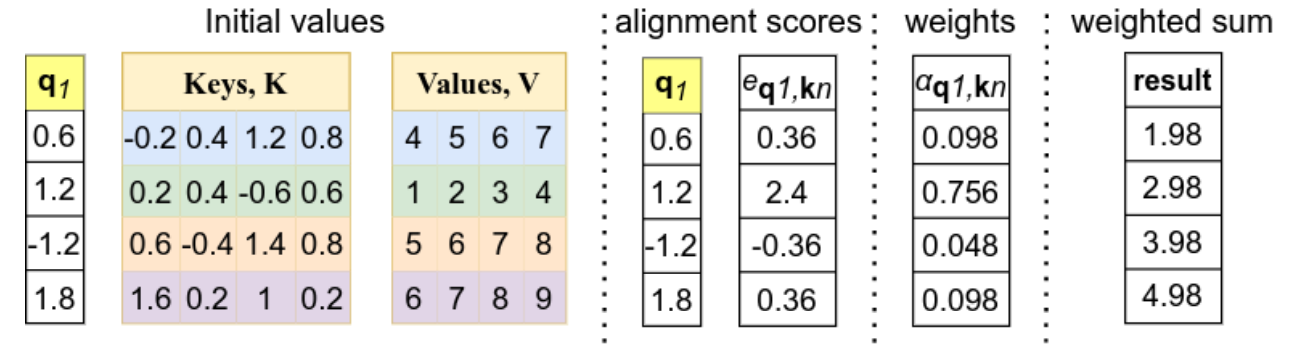

# Transformer

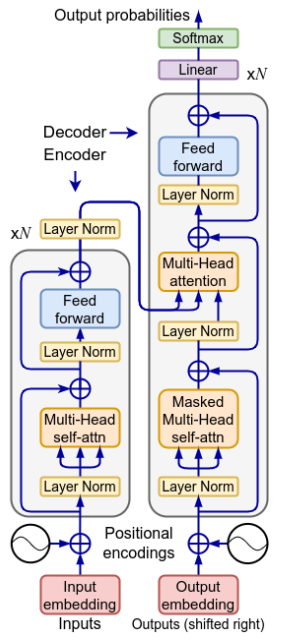

## Data

In [1]:
input_seq = [
    ["salut", "comment", "ca", "va", "?"],
    ["ca", "va", "bien", "merci", "."]
             ]

output_seq = [
    ["<START>", "hi", "how", "are", "you", "?"],
    ["<START>", "it", "is", "okay", "thanks", "."]
]

def get_vocabulary(sequences):
  vocabulary = {}
  vocabulary["<PAD>"] = 0; vocabulary["<UNK>"] = 1; vocabulary["<START>"] = 2; vocabulary["<END>"] = 3
  for sequence in sequences:
    for token in sequence:
      if token not in vocabulary:
        vocabulary[token] = len(vocabulary)
  return vocabulary

input_voc = get_vocabulary(input_seq)
output_voc = get_vocabulary(output_seq)

print(input_voc)
print(output_voc)

{'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3, 'salut': 4, 'comment': 5, 'ca': 6, 'va': 7, '?': 8, 'bien': 9, 'merci': 10, '.': 11}
{'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3, 'hi': 4, 'how': 5, 'are': 6, 'you': 7, '?': 8, 'it': 9, 'is': 10, 'okay': 11, 'thanks': 12, '.': 13}


In [2]:
import copy
import numpy as np
import torch

def seq_to_int(sequences, voc):
  sequences_copy = copy.deepcopy(sequences)
  for sequence in sequences_copy:
    for i, word in enumerate(sequence):
      if word in voc:
        sequence[i] = voc[word]
      else:
        sequence[i] = voc["<UNK>"]
  return(np.array(sequences_copy))

input_to_int = seq_to_int(input_seq, input_voc)
output_to_int = seq_to_int(output_seq, output_voc)

print(input_to_int)
print(output_to_int)

[[ 4  5  6  7  8]
 [ 6  7  9 10 11]]
[[ 2  4  5  6  7  8]
 [ 2  9 10 11 12 13]]


## Embedding

In [3]:
tensor_input_to_int = torch.tensor(input_to_int, dtype=int)
input_embedding = torch.nn.Embedding(len(input_voc), 4)

vector_embedding = input_embedding(tensor_input_to_int)
vector_embedding

tensor([[[ 1.0971, -0.4470, -0.7090,  0.0655],
         [ 0.6274,  0.8837,  1.4664,  0.0608],
         [-1.4301, -1.2285, -0.5216, -0.7290],
         [-0.2411,  0.0942, -0.0416,  0.8612],
         [ 2.3759,  0.3428, -0.3143, -0.4129]],

        [[-1.4301, -1.2285, -0.5216, -0.7290],
         [-0.2411,  0.0942, -0.0416,  0.8612],
         [ 0.3156,  2.0720,  0.0324,  1.3150],
         [-0.8938,  0.4908,  0.2275,  1.4114],
         [ 1.6784,  0.1023, -0.7178,  0.6961]]], grad_fn=<EmbeddingBackward0>)

## Encoder

In [59]:
################# Avoir plusieurs modudes avec des références différentes #################
def clones(module, n):
    return torch.nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

################# Scaled Dot Product Attention #################
def ScaledDotProductAttention(Q, K, V, mask = None):
  """
  Q : Query head ; shape : batch x n_head x n_token x d_head
  K : Key head ; shape : batch x n_head x n_token x d_head
  V : Value head ; shape : batch x n_head x n_token x d_head
  """

  d_head = Q.size(-1)
  scores = torch.matmul(Q, K.transpose(-2,-1)) / np.sqrt(d_head) # shape : batch * n_head * n_token * n_token
  if mask is not None:
    scores.masked_fill_(mask==0, -1e9)

  weights = scores.softmax(-1)
  return torch.matmul(weights, V), weights

################# Multi-Head Attention #################
class Multi_Head_Attention(torch.nn.Module):
  def __init__(self, n_head, d_model, dropout=0.1):
    super(Multi_Head_Attention, self).__init__()
    assert d_model % n_head == 0
    self.n_head = n_head
    self.d_head = d_model // n_head
    self.layers = clones(torch.nn.Linear(d_model, d_model), 4)
    self.weights = None
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, Q, K, V, mask=None):
    """
    Q : Query embedding ; shape : batch x n_token x d_model
    K : Key embedding ; shape : batch x n_token x d_model
    V : Value embedding ; shape : batch x n_token x d_model
    """
    if mask is not None:
      mask.unsqueeze(1)

    batch_size = Q.size(0)
    Q, K, V = [l(x).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2) for l, x in zip(self.layers, (Q, K, V))] # batch x n_head x n_token x d_head
    x, self.weights = ScaledDotProductAttention(Q, K, V) # batch x n_head x n_token x d_head
    x = x.transpose(1,2).contiguous().view(batch_size, -1, self.n_head * self.d_head) # batch x n_token x d_model
    return self.layers[-1](self.dropout(x))

################# FFN #################
class FFN(torch.nn.Module):
  def __init__(self, d_model, d_ffn, dropout=0.1):
    super(FFN, self).__init__()
    self.layer1 = torch.nn.Linear(d_model, d_ffn)
    self.layer2 = torch.nn.Linear(d_ffn, d_model)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, x):
    return self.layer2(self.dropout(torch.nn.functional.silu(self.layer1(x))))

################# Addition et normalisation pre-in #################
class PreNormResidual(torch.nn.Module):
  def __init__(self, d_model, dropout=0.1):
    super(PreNormResidual, self).__init__()
    self.norm = torch.nn.LayerNorm(d_model)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

################# Encoder block #################
class EncoderBlock(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn):
    super(EncoderBlock, self).__init__()
    self.MHA = Multi_Head_Attention(n_head, d_model)
    self.Norm_And_Add = clones(PreNormResidual(d_model), 2)
    self.FFN = FFN(d_model, d_ffn)

  def forward(self, x):
    """
    x : Input ; shape : batch x n_token x d_model
    """
    x = self.Norm_And_Add[0](x, lambda x: self.MHA(x, x, x))
    x = self.Norm_And_Add[1](x, self.FFN)
    return x

################# Encoder #################
class Encoder(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn, N):
    super(Encoder, self).__init__()
    self.layers = clones(EncoderBlock(n_head, d_model, d_ffn), N)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

################# Decoder block #################
class DecoderBlock(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn):
    super(DecoderBlock, self).__init__()
    self.MHA = Multi_Head_Attention(n_head, d_model)
    self.Norm_And_Add = clones(PreNormResidual(d_model), 2)
    self.FFN = FFN(d_model, d_ffn)

  def forward(self, x, mask):
    """
    x : Output ; shape : batch x n_token x d_model
    mask : Mask (padding tokens are masked as well) ; shape : batch x n_token x n_token
    """
    x = self.Norm_And_Add[0](x, lambda x: self.MHA(x, x, x))
    x = self.Norm_And_Add[1](x, self.FFN)
    return x

In [5]:
d_model = 512
d_ffn = 2048
n_head = 8
N = 6


tensor_input_to_int = torch.tensor(input_to_int, dtype=int)
input_embedding = torch.nn.Embedding(len(input_voc), d_model)

vector_embedding = input_embedding(tensor_input_to_int)
vector_embedding

tensor([[[ 0.3973,  1.5026,  0.5145,  ...,  0.4557, -0.3578, -0.3929],
         [-1.0024, -0.0544,  2.0848,  ...,  0.8904,  1.1969,  1.3621],
         [ 0.9010, -1.9829, -0.6318,  ...,  0.1908,  0.2659, -0.1378],
         [ 1.6758, -0.8466,  2.2854,  ..., -0.8114, -0.6492,  0.7304],
         [-2.6799, -1.6923,  1.1378,  ..., -1.4475, -1.1114,  1.0139]],

        [[ 0.9010, -1.9829, -0.6318,  ...,  0.1908,  0.2659, -0.1378],
         [ 1.6758, -0.8466,  2.2854,  ..., -0.8114, -0.6492,  0.7304],
         [ 0.1395,  0.5513,  0.5810,  ..., -0.3541,  1.2448,  0.6710],
         [ 1.7883, -1.7578, -1.0449,  ..., -0.1821, -0.0641,  1.6800],
         [ 0.1412, -0.2740,  0.4060,  ...,  0.8576,  0.4584, -0.9200]]],
       grad_fn=<EmbeddingBackward0>)

In [6]:
model = Encoder(n_head, d_model, d_ffn, N)
model(vector_embedding)

tensor([[[ 0.4966,  1.1556,  1.0712,  ...,  1.8224, -1.9290,  2.2729],
         [-1.5910, -1.4853,  1.1971,  ...,  0.8107,  3.7261,  3.0065],
         [ 0.2745, -0.7005,  0.4448,  ...,  4.1041, -0.7308,  1.2090],
         [ 1.9618,  3.1584,  0.4792,  ...,  0.6677, -1.6970,  2.8930],
         [-4.0915, -0.9944,  0.1568,  ..., -2.3000, -1.5967,  0.9252]],

        [[ 0.8648,  0.2909, -0.8082,  ...,  3.3978,  0.0114,  1.2991],
         [ 3.0949,  2.4999,  1.4982,  ..., -0.4658, -1.1516,  1.5923],
         [ 0.5379,  1.0436,  1.1397,  ..., -0.2014,  3.6386, -0.1239],
         [ 2.2646, -1.5731, -2.2856,  ...,  0.3898,  1.2029,  2.4062],
         [-1.0041,  2.7018, -4.4205,  ...,  3.2449,  2.8340, -0.1422]]],
       grad_fn=<AddBackward0>)

In [78]:
# x : Input ; shape : batch * n_head * n_token * d_model
n_token = 5
n_head = 3
batch_size = 2
mask = torch.tril(torch.ones(batch_size, n_token, n_token)).unsqueeze(1).bool()
mask[-1,-1,-1,-1] = False
print(mask)
print(mask.shape)

tensor([[[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]],


        [[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True, False]]]])
torch.Size([2, 1, 5, 5])


In [79]:
QK = torch.randint(-2,3,(batch_size, n_head, n_token, n_token)).float()
QK

tensor([[[[ 1.,  2.,  2.,  1.,  2.],
          [ 1.,  1.,  2.,  2., -1.],
          [ 1.,  1., -1.,  1., -1.],
          [ 1.,  0.,  2.,  1., -2.],
          [ 1., -1., -2., -2.,  2.]],

         [[ 0.,  1., -2., -1.,  2.],
          [ 0.,  0., -2.,  2., -1.],
          [ 2.,  1., -1., -2.,  1.],
          [ 1.,  1., -2., -1., -1.],
          [ 0.,  2.,  1.,  1.,  0.]],

         [[-1.,  0., -1.,  0.,  0.],
          [ 2., -1.,  1.,  2., -1.],
          [-2.,  2.,  1.,  1.,  2.],
          [-1.,  1., -2.,  1.,  2.],
          [ 0.,  1., -1., -2.,  2.]]],


        [[[ 0., -1.,  0.,  2.,  1.],
          [ 0., -1., -1.,  0., -1.],
          [-1.,  2., -2.,  0., -1.],
          [ 1., -1., -1.,  0., -2.],
          [-2.,  2.,  2., -1., -1.]],

         [[ 2., -1., -1.,  1., -2.],
          [ 0., -1.,  2.,  0., -2.],
          [ 0., -2.,  2.,  2., -1.],
          [-2.,  2.,  0.,  0., -1.],
          [-1.,  0., -2.,  0.,  2.]],

         [[ 1.,  2.,  1.,  2., -1.],
          [ 1.,  2., -2., 

In [80]:
QK.masked_fill_(mask==0, -1e9).softmax(dim=-1)

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
          [0.4683, 0.4683, 0.0634, 0.0000, 0.0000],
          [0.1966, 0.0723, 0.5344, 0.1966, 0.0000],
          [0.2530, 0.0342, 0.0126, 0.0126, 0.6876]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
          [0.7054, 0.2595, 0.0351, 0.0000, 0.0000],
          [0.4576, 0.4576, 0.0228, 0.0619, 0.0000],
          [0.0675, 0.4984, 0.1834, 0.1834, 0.0675]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.9526, 0.0474, 0.0000, 0.0000, 0.0000],
          [0.0132, 0.7214, 0.2654, 0.0000, 0.0000],
          [0.0619, 0.4576, 0.0228, 0.4576, 0.0000],
          [0.0861, 0.2341, 0.0317, 0.0117, 0.6364]]],


        [[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.7311, 0.2689, 0.0000, 0.0000, 0.0000],
          [0.0466, 0.9362, 0.0171, 0.0000, 0.0000],
          [0.6103, 0.0826, 0.0826, 0.2245, 0.0000],
    